# Influence functions for data mis-labelling

Both data mis-labelling and outlier detection target the same problem, they are operating on discrete and continuous values, respectively. Imagine a simple classification problem, where $y_i \in \{1, \dots, K\}$, the goal is now to find labels which are mislabelled. In our case we further simplify the problem to set $K=2$.

## Using a 2-class GMM to sample articial data

Multiple means $\mu_1, \dots, \mu_k$, a single standard deviation $\sigma$ are required

In [1]:
import numpy as np

sigma = 0.2
mus = np.asarray([
    [0.0, 0.0],
    [1.0, 1.0]
])


num_classes = len(mus)
num_samples = 1000
num_features = 2

in the following

$$
y_i \sim \text{Cat}\left ( K, p=\frac{1}{K} \right) \\
x_i \sim \mathcal{N}\left (\cdot |\mu_{y_i}, \sigma^2 I \right),
$$

Gaussian mixture model (GMM). Sampling is fairly easy and can be done by sampling $N$ target data points from a categorical distribution. Afterwards the features can be obtained by using the previously sampled target labels.

In [2]:
from valuation.utils import Dataset
from sklearn.model_selection import train_test_split

gaussian_cov = sigma * np.eye(num_features)
gaussian_chol = np.linalg.cholesky(gaussian_cov)
y = np.random.randint(num_classes, size=num_samples)
x = np.einsum('ij,kj->ki', gaussian_chol, np.random.normal(size=[num_samples, num_features])) + mus[y]

Using this model This has two advantages:

1. Bayesian decision theory gives the optimal decision boundary to use in the plots.
2. The highest level zones for the influences have a low margin zone right above the decision boundary.

### Decision Boundary

First a formula for the decision boundary f(x) in the two-class case is derived

$$
\begin{align*}
\| x - \mu_1 \|^2 &= \| x - \mu_2 \|^2 \\
\| \mu_1 \|^2 -2 x^\mathsf{T} \mu_1 &= \| \mu_2 \|^2 -2 x^\mathsf{T} \mu_2 \\
\implies 0 &= 2 (\mu_2 - \mu_1)^\mathsf{T} x + \| \mu_1 \|^2 - \| \mu_2 \|^2 \\
\frac{1}{2} \mu_1^\mathsf{T} \mu_1 - \frac{1}{2} \mu_2^\mathsf{T} \mu_2 &= \mu_1^\mathsf{T}b - \mu_2^\mathsf{T}b
\end{align*}
$$


A functional form $f(z) = x = a z + b$ with $z \in \mathbf{R}$ is assumed. It is now straightforward to write the decision function

$$
\begin{align*}
0 &= (\mu_2 - \mu_1)^\mathsf{T} (at + b) + \frac{1}{2} \| \mu_1 \|^2 - \| \mu_2 \|^2 \\
\implies f(t) &= \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix} (\mu_2 - \mu_1) t + \frac{\mu_1 + \mu_2}{2}
\end{align*}
$$

with vectors $a, b \in \mathbf{R}^2$. Now it is possible to define the view and the decision boundary.

In [3]:
x_min = np.asarray([-2, -2])
x_max = np.asarray([3, 3])
z_linspace = np.linspace(-1.5, 1.5, 100).reshape([-1, 1])

a = np.asarray([[0, 1], [-1, 0]]) @ (mus[1] - mus[0])
b = np.sum(mus, axis=0) / 2
a = a.reshape([1, -1])
decision_boundary = z_linspace * a + b

### Visualizing the dataset

The next step is to wrap the previously generated data into a dataset with separate training and test set.

In [4]:
arg_flipper = lambda x1, x2, y1, y2: (x1, y1, x2, y2)
dataset = Dataset(*arg_flipper(*train_test_split(x, y, train_size=0.70)))

It is always a good idea to visualize the dataset. In the 2-dimensional case it is rather straight forward. Each class is represented by a unique color.

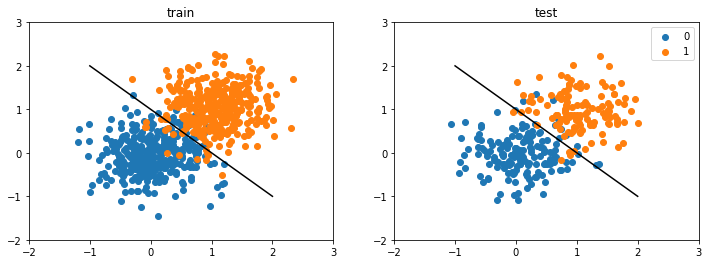

In [5]:
import matplotlib.pyplot as plt

datasets = {
    'train': (dataset.x_train, dataset.y_train),
    'test': (dataset.x_test, dataset.y_test)
}
num_datasets = len(datasets)
fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))

for i, dataset_name in enumerate(datasets.keys()):
    x, y = datasets[dataset_name]
    ax[i].set_title(dataset_name)
    ax[i].set_xlim(x_min[0], x_max[0])
    ax[i].set_ylim(x_min[1], x_max[1])
    ax[i].plot(decision_boundary[:, 0], decision_boundary[:, 1], color="black")

    for v in np.unique(y):
        idx = np.argwhere(y == v)
        ax[i].scatter(x[idx, 0], x[idx, 1], label=str(v))


plt.legend()
plt.show()

Note that both the train and test set are plotted side by side as well as the previously determined decision boundary. As one can see the two classes slightly overlap, and it is expected that these samples have a higher influence on the remaining sample region. An example on how to verify this statement and hence calculate the influences is given in the next section.

## Calculating influences using a (differentiable) logistic regression model

For the example dataset above an adequate model has to be found. Intuitively and probably the best choice is a simple logistic regression model.

### Fitting a logistic regression model via gradient descent to the data

Using the pyDVL valuation library a model can be formalized and fitted by using

In [6]:
from valuation.models.pytorch_model import PyTorchSupervisedModel, PyTorchOptimizer
from valuation.models.binary_logistic_regression import BinaryLogisticRegressionTorchModel
import torch.nn.functional as F

model = PyTorchSupervisedModel(
    model=BinaryLogisticRegressionTorchModel(num_features),
    objective=F.binary_cross_entropy,
    num_epochs=1000,
    batch_size=128,
    optimizer=PyTorchOptimizer.ADAM_W,
    optimizer_kwargs={
        "lr": 0.005,
        "weight_decay": 0.005
    },
)
model.fit(
    dataset.x_train,
    dataset.y_train
)

Training loss: 0.7066325545310974
Training loss: 0.7024267911911011
Training loss: 0.7005719542503357
Training loss: 0.697394847869873
Training loss: 0.695200502872467
Training loss: 0.6915693283081055
Training loss: 0.6894288063049316
Training loss: 0.6874507665634155
Training loss: 0.6838330030441284
Training loss: 0.6839855909347534
Training loss: 0.6799867749214172
Training loss: 0.6746931076049805
Training loss: 0.6732413172721863
Training loss: 0.6729904413223267
Training loss: 0.6677899360656738
Training loss: 0.6708747744560242
Training loss: 0.6651642322540283
Training loss: 0.6586271524429321
Training loss: 0.6577944755554199
Training loss: 0.6590090990066528
Training loss: 0.6523709297180176
Training loss: 0.6580402255058289
Training loss: 0.6507071852684021
Training loss: 0.6432844400405884
Training loss: 0.6430134177207947
Training loss: 0.6454656720161438
Training loss: 0.6375317573547363
Training loss: 0.6454803943634033
Training loss: 0.6366101503372192
Training loss: 0

Note how the objective is specified in the model class, because the Hessian and scores calculated throughout are with respect to this loss function.

### Calculating influences

Next the influences with respect to the previously fitted logistic regression model are calculated. A influence function $I(x_1, x_2) \colon \mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R} $ measures the influence of the data point $x_1$ onto $x_2$ conditioned on the training targets $y_1$ and $y_2$. As long as the loss function $L(x, y)$ is differentiable (or can be approximated by a surrogate objective).

In [7]:
from valuation.influence.general import influences
from valuation.influence.types import InfluenceTypes
train_influences = influences(
    model,
    dataset.x_train,
    dataset.y_train,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)
test_influences = influences(
    model,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)

#### Plotting the mean influences of the training and test samples onto the test samples

Next the mean absolute influences $\text{MAI}(x) = \frac{1}{N} \sum_{i=1}^N | I(x, x_i) |$ of all (including training and test set) is calculated.

In [8]:
mean_influences = lambda arr: np.mean(np.abs(arr), axis=0)
mean_train_influences = mean_influences(train_influences)
mean_test_influences = mean_influences(test_influences)

And afterwards visualized by

<Figure size 432x288 with 0 Axes>

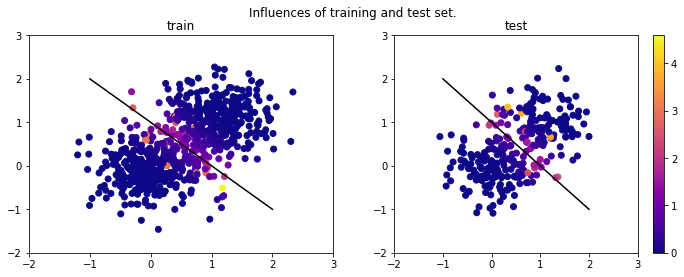

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))
mean_influences = {
    'train': mean_train_influences,
    'test': mean_test_influences
}
v_max = max(np.max(mean_train_influences), np.max(mean_test_influences))
for i, dataset_name in enumerate(datasets.keys()):
    x = datasets[dataset_name][0].copy()
    ax[i].set_title(dataset_name)
    ax[i].set_xlim(x_min[0], x_max[0])
    ax[i].set_ylim(x_min[1], x_max[1])
    ax[i].plot(decision_boundary[:, 0], decision_boundary[:, 1], color="black")
    points = ax[i].scatter(x[:, 0], x[:, 1], c=mean_influences[dataset_name], vmin=0, vmax=v_max, cmap="plasma")

plt.suptitle("Influences of training and test set.")
plt.colorbar(points)
plt.show()

## Flipping 5% of the labels of the training set and identify them

It is assumed that our reference test set is not flipped and was checked. As the test set is much smalled then the train set, this is a viable solution. In comparison to the correct test set, 5% of the training set get flipped at random positions. Next it is shown how to identify flipped examples

In [17]:
from copy import copy

flip_percentage = 0.05
flipped_dataset = copy(dataset)
flip_num_samples = int(flip_percentage * len(dataset.x_train))
idx = np.random.choice(len(dataset.x_train), replace=False, size=flip_num_samples)
flipped_dataset.y_train[idx] = 1 - flipped_dataset.y_train[idx]

### Identifying data points with absurd high absolute mean influences on the test set

Start by calculating the influences and derive the absolute mean influences

In [22]:
flipped_train_test_influences = influences(
    model,
    flipped_dataset.x_train,
    flipped_dataset.y_train,
    flipped_dataset.x_test,
    flipped_dataset.y_test,
    influence_type=InfluenceTypes.Up
)
mean_flipped_train_test_influences = np.mean(np.abs(flipped_train_test_influences), axis=0)

To make an comparison how good it approximates the randomly flipped samples, we take the 5% training samples with the highest absolute mean influence and measure the accuracy.

In [25]:
from IPython.core.display_functions import display

estimated_idx = np.flip(np.argsort(mean_flipped_train_test_influences))[:len(idx)]
found_elements = set(estimated_idx).intersection(set(idx))
remaining_element = set(idx).difference(set(estimated_idx))
display(f"Around {100* len(found_elements) / len(idx):.2f}% could be identified. But there are {100* len(remaining_element) / len(idx):.2f}% remaining samples")

'Around 25.71% could be identified. But there are 74.29% remaining samples'

As we can see it is very easy to identify the majority of the 5% flipped data samples.

### Inspecting not corrected samples

However, some cases still fail to be detected, by this simple mechanism.  They are visualized in the following plot:

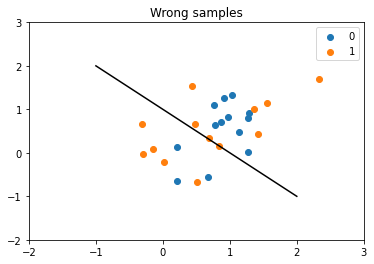

In [24]:
import matplotlib.pyplot as plt

remaining_idx = np.asarray(list(remaining_element), dtype=int)
plt.figure()
y = flipped_dataset.y_train[remaining_idx]
plt.title("Wrong samples")
plt.xlim(x_min[0], x_max[0])
plt.ylim(x_min[1], x_max[1])
plt.plot(decision_boundary[:, 0], decision_boundary[:, 1], color="black")

for v in np.unique(y):
    sub_idx = np.argwhere(y == v)
    c_idx = remaining_idx[sub_idx]
    plt.scatter(flipped_dataset.x_train[c_idx, 0], flipped_dataset.x_train[c_idx, 1], label=str(v))

plt.legend()
plt.show()